## Assignment : 14

In [1]:
%tensorflow_version 1.x
from keras.models import Sequential
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D,Flatten,LSTM,concatenate,Dropout,CuDNNLSTM,SpatialDropout1D
from keras.layers import Conv1D, MaxPooling1D, Embedding,InputLayer,BatchNormalization
from keras.models import Model
from keras.initializers import Constant
from keras.regularizers import l2
#import tensorflow as tf
from keras import backend as K
import pandas as pd
from keras.layers import ReLU

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
from __future__ import print_function
import tqdm
import pickle
import pandas as pd
import numpy as np
import os
import sys
from keras.models import Sequential
from keras.layers import Dense,Input
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [0]:

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from scipy.sparse import hstack
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import LSTM,Bidirectional
from keras.layers.core import Dense, Dropout
from keras.models import Model, load_model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
project_data=pd.read_csv("/content/drive/My Drive/prs.csv")

In [6]:
from sklearn.model_selection import train_test_split
# split the data set into train and test respectively 80% and 20%
y=project_data['project_is_approved']
project_data.drop(['project_is_approved'],axis=1, inplace=True)
x=project_data
X_temp,X_test,Y_temp,Y_test=train_test_split(x,y,test_size=0.2)
# split the data set into train and cv respectively 60% and 20%  
X_train,X_cv,Y_train,Y_cv=train_test_split(X_temp,Y_temp,test_size=0.2)
print("Shape of Train data set X={} Y={}".format(X_train.shape,Y_train.shape))
print("Shape of Test data set X={} Y={}".format(X_test.shape,Y_test.shape))
print("Shape of CV data set X={} Y={}".format(X_cv.shape,Y_cv.shape))

Shape of Train data set X=(69918, 9) Y=(69918,)
Shape of Test data set X=(21850, 9) Y=(21850,)
Shape of CV data set X=(17480, 9) Y=(17480,)


In [0]:
y_train = to_categorical(Y_train)
y_cv = to_categorical(Y_cv)
y_test = to_categorical(Y_test)

In [0]:
len_essay=[]
for sentance1 in (X_train['essay'].values):
    len_essay.append(len(sentance1.split()))
num_essay=np.array(len_essay)
max_length=num_essay.max()

In [0]:
#text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['essay'])
train_encoded_essays = tokenizer.texts_to_sequences(X_train['essay'])
train_padded_essays = pad_sequences(train_encoded_essays, maxlen=max_length,padding='post')

test_encoded_essays = tokenizer.texts_to_sequences(X_test['essay'])
test_padded_essays = pad_sequences(test_encoded_essays, maxlen=max_length,padding='post')


cv_encoded_essays = tokenizer.texts_to_sequences(X_cv['essay'])
cv_padded_essays = pad_sequences(cv_encoded_essays, maxlen=max_length,padding='post')

vocab_size = len(tokenizer.word_index) + 1

In [10]:
from sklearn.preprocessing import StandardScaler
#essay_stand = StandardScaler().fit(train_padded_essays)
tr_text__nor = train_padded_essays
cv_text__nor = cv_padded_essays
te_text__nor = test_padded_essays
print(tr_text__nor.shape)

(69918, 315)


In [0]:
#loading golve model
import pickle
with open('/content/drive/My Drive/glove_vectors', 'rb') as f:
    glove = pickle.load(f)

In [0]:
word_vector=np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    vector=glove.get(word)
    if vector is not None:
        word_vector[i]=vector   

In [13]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html


# price_standardized = standardScalar.fit(X_train['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
tr_price_standardized=price_scalar.fit_transform(X_train['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
cv_price_standardized = price_scalar.transform(X_cv['price'].values.reshape(-1, 1))
te_price_standardized = price_scalar.transform(X_test['price'].values.reshape(-1, 1))
print(tr_price_standardized.shape)

Mean : 298.3500094396293, Standard deviation : 369.7265369517227
(69918, 1)


In [14]:
#teacher_number_of_previously_posted_projects
teacher_number_of_previously_posted_projects_scalar = StandardScaler()
tr_teacher_number_of_previously_posted_projects_standardized=teacher_number_of_previously_posted_projects_scalar.fit_transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {teacher_number_of_previously_posted_projects_scalar.mean_[0]}, Standard deviation : {np.sqrt(teacher_number_of_previously_posted_projects_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
cv_teacher_number_of_previously_posted_projects_standardized = teacher_number_of_previously_posted_projects_scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
te_teacher_number_of_previously_posted_projects_standardized = teacher_number_of_previously_posted_projects_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
print("\nShape of matrix after column standardization for 'teacher_number_of_previously_posted_projects'\nTrain data-{},\nCV data\t-{}\nTest data-{}".format(tr_teacher_number_of_previously_posted_projects_standardized.shape,cv_teacher_number_of_previously_posted_projects_standardized.shape,te_teacher_number_of_previously_posted_projects_standardized.shape))

Mean : 11.191495752166825, Standard deviation : 27.829357536069097

Shape of matrix after column standardization for 'teacher_number_of_previously_posted_projects'
Train data-(69918, 1),
CV data	-(17480, 1)
Test data-(21850, 1)


In [0]:
#https://stackoverflow.com/posts/51734992/revisions
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [16]:
from sklearn import preprocessing
vocab_size_cat=len(X_train['clean_categories'].unique())+1
print(vocab_size_cat)
le = preprocessing.LabelEncoder()
le.fit(X_train['clean_categories'])
tr_categories_le=le.transform(X_train['clean_categories'])
X_test["clean_categories"] = X_test["clean_categories"].map(lambda s: ' ' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, ' ')
te_categories_le=le.transform(X_test['clean_categories'].values)
X_cv["clean_categories"] = X_cv["clean_categories"].map(lambda s: ' ' if s not in le.classes_ else s)
cv_categories_le=le.transform(X_cv['clean_categories'].values)

52


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [17]:
from sklearn import preprocessing
vocab_size_state=len(X_train['school_state'].unique())+1
print(vocab_size_state)
le = preprocessing.LabelEncoder()
le.fit(X_train['school_state'])
tr_school_state_le=le.transform(X_train['school_state'])
X_test["school_state"] = X_test["school_state"].map(lambda s: ' ' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, ' ')
te_school_state_le=le.transform(X_test['school_state'].values)
X_cv["school_state"] = X_cv["school_state"].map(lambda s: ' ' if s not in le.classes_ else s)
cv_school_state_le=le.transform(X_cv['school_state'].values)

52


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [18]:
from sklearn import preprocessing
vocab_size_te_pr=len(X_train['teacher_prefix'].unique())+1
print(vocab_size_te_pr)
le = preprocessing.LabelEncoder()
le.fit(X_train['teacher_prefix'])
tr_teacher_prefix_le=le.transform(X_train['teacher_prefix'])
X_test["teacher_prefix"] = X_test["teacher_prefix"].map(lambda s: ' ' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, ' ')
te_teacher_prefix_le=le.transform(X_test['teacher_prefix'].values)
X_cv["teacher_prefix"] = X_cv["teacher_prefix"].map(lambda s: ' ' if s not in le.classes_ else s)
cv_teacher_prefix_le=le.transform(X_cv['teacher_prefix'].values)

6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [19]:
from sklearn import preprocessing
vocab_size_gra_cat=len(X_train['project_grade_category'].unique())+1
print(vocab_size_gra_cat)
le = preprocessing.LabelEncoder()
le.fit(X_train['project_grade_category'])
tr_project_grade_category_le=le.transform(X_train['project_grade_category'])
X_test["project_grade_category"] = X_test["project_grade_category"].map(lambda s: ' ' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, ' ')
te_project_grade_category_le=le.transform(X_test['project_grade_category'].values)
X_cv["project_grade_category"] = X_cv["project_grade_category"].map(lambda s: ' ' if s not in le.classes_ else s)
cv_project_grade_category_le=le.transform(X_cv['project_grade_category'].values)

5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [20]:
from sklearn import preprocessing
vocab_size_sub_cat=len(X_train['clean_subcategories'].unique())+1
print(vocab_size_sub_cat)
le = preprocessing.LabelEncoder()
le.fit(X_train['clean_subcategories'])
tr_clean_subcategories_le=le.transform(X_train['clean_subcategories'])
X_test["clean_subcategories"] = X_test["clean_subcategories"].map(lambda s: ' ' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, ' ')
te_clean_subcategories_le=le.transform(X_test['clean_subcategories'].values)
X_cv["clean_subcategories"] = X_cv["clean_subcategories"].map(lambda s: ' ' if s not in le.classes_ else s)
cv_clean_subcategories_le=le.transform(X_cv['clean_subcategories'].values)

394


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [21]:
from numpy import hstack
tr_X_num= hstack((tr_price_standardized,tr_teacher_number_of_previously_posted_projects_standardized))
cv_X_num= hstack((cv_price_standardized,cv_teacher_number_of_previously_posted_projects_standardized))
te_X_num= hstack((te_price_standardized,te_teacher_number_of_previously_posted_projects_standardized))
print(tr_X_num.shape)
print(cv_X_num.shape)
print(te_X_num.shape)

(69918, 2)
(17480, 2)
(21850, 2)


<h1>Model-1

In [0]:
#model one hot
e=64
K.clear_session()
#model = Sequential()
#total text data
input_total_text=Input(shape=(max_length,),name="input_seq_total_text_dat")
emedding_layer_total_text = Embedding(vocab_size,300, weights=[word_vector], input_length=max_length, trainable=False,name="emb_text_data")(input_total_text)
lstm_layer_total_text=LSTM(64,kernel_initializer='glorot_normal',recurrent_dropout=0.5,return_sequences=True)(emedding_layer_total_text)
#lstm_layer_total_text= ReLU()(lstm_layer_total_text)
flat_layer_total_text=Flatten()(lstm_layer_total_text)

#project state
input_state=Input(shape=(1,),name="input_school_state")
emedding_layer_state = Embedding(vocab_size_state,26,name="emb_state_data")(input_state)
flat_layer_state=Flatten()(emedding_layer_state)

#project grade
input_grade=Input(shape=(1,),name="input_project_grade_category")
emedding_layer_grade = Embedding(vocab_size_gra_cat,3,name="emb_pgc_data")(input_grade)
flat_layer_grade=Flatten()(emedding_layer_grade)

#project categiries
input_categories=Input(shape=(1,),name="input_clean_categories")
emedding_layer_cat = Embedding(vocab_size_cat,26,name="emb_clean_categoriesa")(input_categories)
flat_layer_cat=Flatten()(emedding_layer_cat)

#project subcategiries
input_subcategories=Input(shape=(1,),name="input_clean_subcategories")
emedding_layer_subcat = Embedding(vocab_size_sub_cat,50,name="emb_clean_subcategoriesa")(input_subcategories)
flat_layer_subcat=Flatten()(emedding_layer_subcat)

#Project teacher_prefix
input_teach_prefix=Input(shape=(1,),name="input_teach_prefix")
emedding_layer_teach_prefix = Embedding(vocab_size_te_pr,3,name="emb_teach_prefix_data")(input_teach_prefix)
flat_layer_teach_prefix=Flatten()(emedding_layer_teach_prefix)

#number data price and teacher_number_of_previously_posted_projects
input_num=Input(shape=(2,),name="input_price_teacher_number_posted_project")
dense_layer_price_num_project=Dense(64, activation='sigmoid',name="Dense_rem_input",kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(input_num)

concat_layer=concatenate(inputs=[flat_layer_total_text,flat_layer_cat,flat_layer_subcat,flat_layer_state,flat_layer_teach_prefix,dense_layer_price_num_project],name="concatenate")
#BN_1=BatchNormalization()(concat_layer)
#dense layer 1
dense_layer_after_concat=Dense(32,name="Dense_layer_after_concat",kernel_initializer='he_normal',activation='relu',kernel_regularizer=l2(0.001))(concat_layer)
#dense_layer_after_concat=ReLU()(dense_layer_after_concat)
#dropout layer 1
dropout_1=Dropout(0.8,name="Dropout_1")(dense_layer_after_concat)
#dense layer 2
dense_layer_after_concat_2=Dense(16,name="Dense_layer_after_concat_2",kernel_initializer='he_normal',activation='relu',kernel_regularizer=l2(0.001))(dense_layer_after_concat)
#dense_layer_after_concat_2=ReLU()(dense_layer_after_concat_2)
#dropout layer 2
dropout_2=Dropout(0.8,name="Dropout_2")(dense_layer_after_concat_2)
#dense layer 3
dense_layer_after_concat_3=Dense(8,name="Dense_layer_after_concat_3",kernel_initializer='he_normal',activation='relu',kernel_regularizer=l2(0.001))(dense_layer_after_concat_2)
#dense_layer_after_concat_3=ReLU()(dense_layer_after_concat_3)
dropout_3=Dropout(0.8,name="Dropout_3")(dense_layer_after_concat_3)

dense_layer_after_concat_4=Dense(16,name="Dense_layer_after_concat_4",kernel_initializer='he_normal',activation='relu',kernel_regularizer=l2(0.001))(dense_layer_after_concat_3)
#dense_layer_after_concat_4=ReLU()(dense_layer_after_concat_4)

output_layer=Dense(2, activation='softmax',kernel_initializer='glorot_uniform')(dense_layer_after_concat_4)

model=Model(inputs=[input_total_text,input_state,input_grade,input_categories,input_subcategories,input_teach_prefix,input_num],outputs=output_layer)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


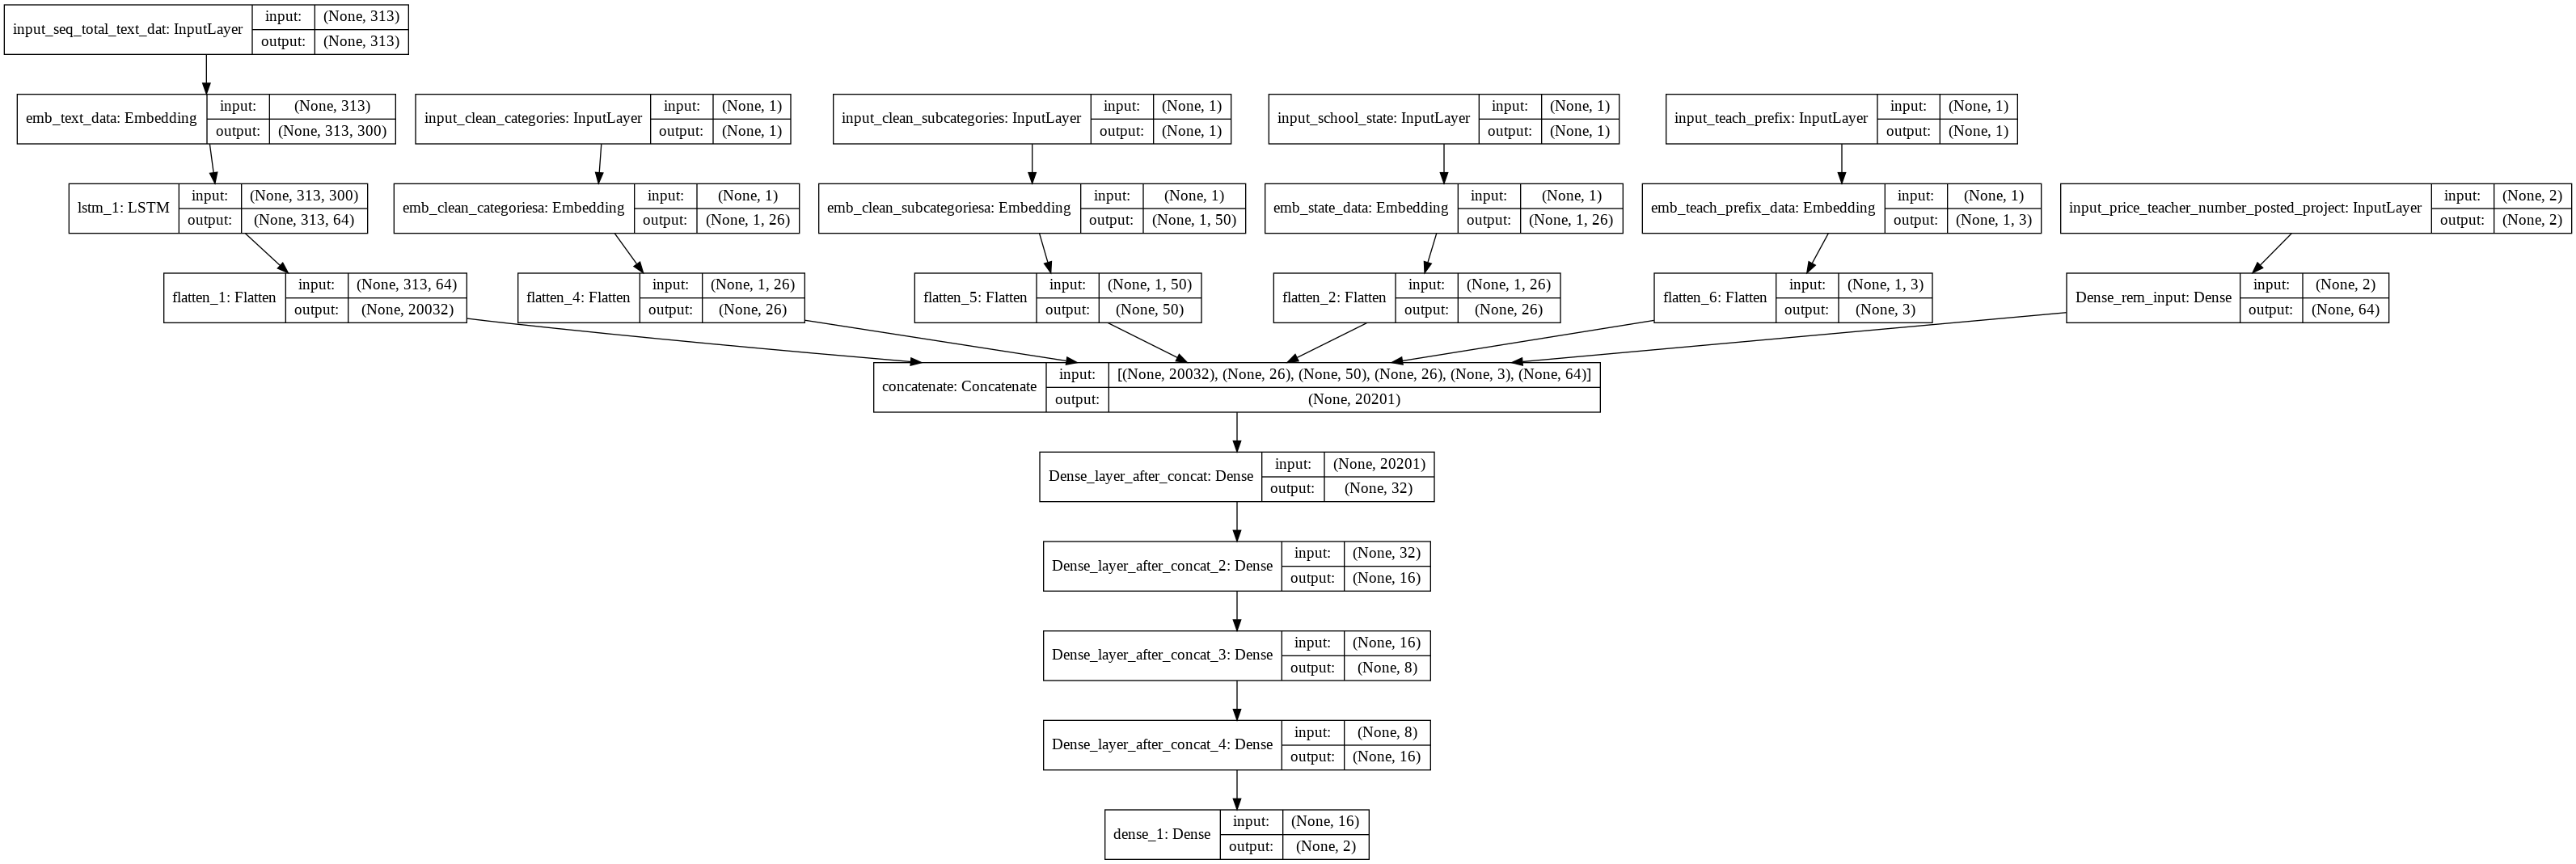

In [0]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/My Drive/model1.png', show_shapes=True, show_layer_names=True)

In [0]:
# summarize the model
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_seq_total_text_dat (Input (None, 313)          0                                            
__________________________________________________________________________________________________
emb_text_data (Embedding)       (None, 313, 300)     14102100    input_seq_total_text_dat[0][0]   
__________________________________________________________________________________________________
input_clean_categories (InputLa (None, 1)            0                                            
__________________________________________________________________________________________________
input_clean_subcategories (Inpu (None, 1)            0                                            
____________________________________________________________________________________________

In [0]:
adam=keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=[auroc])

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath="/content/drive/My Drive/1epochs:{epoch:03d}.hdf5"
checkpoint_3 = ModelCheckpoint(filepath, monitor='val_auroc', verbose=1, mode='max',  save_best_only=True  )

In [0]:
#https://github.com/taomanwai/tensorboardcolab/
from time import time
import keras
from tensorboardcolab import *
#https://github.com/taomanwai/tensorboardcolab/
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://b690347c.ngrok.io


In [0]:
#reduce_lr_1 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.002,verbose = 1)

callbacks_list = [checkpoint_3,TensorBoardColabCallback(tbc)]

In [0]:

history=model.fit([tr_text__nor,tr_school_state_le,tr_project_grade_category_le,tr_categories_le,tr_clean_subcategories_le,tr_teacher_prefix_le,tr_X_num],y_train,epochs=20,batch_size=400,verbose=1,validation_data=([cv_text__nor,cv_school_state_le,cv_project_grade_category_le,cv_categories_le,cv_clean_subcategories_le,cv_teacher_prefix_le,cv_X_num], y_cv),callbacks=callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 69918 samples, validate on 17480 samples


Epoch 1/20
69918/69918 [==============================] - 124s 2ms/step - loss: 0.5961 - auroc: 0.6743 - val_loss: 0.5452 - val_auroc: 0.7247

Epoch 00001: val_auroc improved from -inf to 0.72469, saving model to /content/drive/My Drive/1epochs:001.hdf5

Epoch 2/20
69918/69918 [==============================] - 121s 2ms/step - loss: 0.5087 - auroc: 0.7422 - val_loss: 0.4990 - val_auroc: 0.7384

Epoch 00002: val_auroc improved from 0.72469 to 0.73842, saving model to /content/drive/My Drive/1epochs:002.hdf5
Epoch 3/20
69918/69918 [==============================] - 120s 2ms/step - loss: 0.4654 - auroc: 0.7651 - val_loss: 0.4757 - val_auroc: 0.7429

Epoch 00003: val_auroc improved from 0.73842 to 0.74294, saving model to /content/drive/My Drive/1epochs:003.hdf5
Epoch 4/20
69918/69918 [==============================] - 118s 2ms/step - loss: 0.4

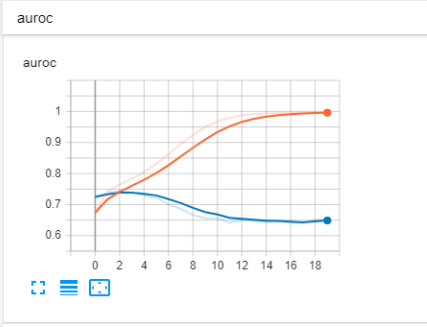

In [0]:
from IPython.display import Image
Image('C:\\Users\\nnagari\\Downloads\\model_1_auc.PNG')

In [0]:
model.load_weights('/content/drive/My Drive/1epochs:002.hdf5')

In [0]:

model.evaluate([te_text__nor,te_school_state_le,te_project_grade_category_le,te_categories_le,te_clean_subcategories_le,te_teacher_prefix_le,te_X_num],y_test,batch_size=100)

21850/21850 [==============================] - 36s 2ms/step


[0.49255993580381713, 0.7532410295213476]

<h1>Model-2

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer_text = TfidfVectorizer(min_df=6,use_idf=True)
#Fitting train data and transforming  train ,cv and test to get idf values
tr_text_tfidf=tfidf_vectorizer_text.fit_transform(X_train['essay'])
cv_text_tfidf = tfidf_vectorizer_text.transform(X_cv['essay'])
te_text_tfidf = tfidf_vectorizer_text.transform(X_test['essay'])
print("Shape of matrix TFIDF Vectorizer on text \nTrain data-{},\nTest data-{}".format(tr_text_tfidf.shape,te_text_tfidf.shape))

Shape of matrix TFIDF Vectorizer on text 
Train data-(69918, 17213),
Test data-(21850, 17213)


In [0]:
#storing idf_values and feature_name
idf_feature=pd.DataFrame(tfidf_vectorizer_text.idf_,columns=['idf_values'])
idf_feature['feature_name']=tfidf_vectorizer_text.get_feature_names()
#sorting feature_name based on idf_values
idf_feature.sort_values(by=['idf_values'],ascending=False,inplace=True,axis=0)

In [24]:
#idf values and feature name
idf_feature[1995:2000]

,idf_values,feature_name
10423,9.957868,numeral
10416,9.957868,nuisance
12803,9.957868,reptiles
8561,9.957868,kaplan
7993,9.957868,ingrain


Text(0, 0.5, 'IDF score')

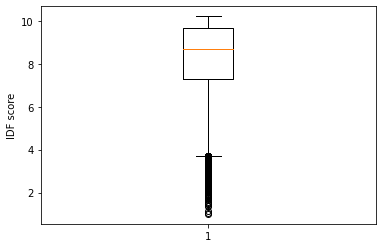

In [25]:
plt.boxplot(idf_feature['idf_values'])
plt.ylabel("IDF score")

In [26]:
for i in range(0,100+1,2):
    print("{}th percentile value = {}".format(i,np.percentile(idf_feature['idf_values'],[i])))

0th percentile value = [1.00773879]
2th percentile value = [3.78169623]
4th percentile value = [4.55189367]
6th percentile value = [5.05071864]
8th percentile value = [5.40394448]
10th percentile value = [5.69675442]
12th percentile value = [5.97507605]
14th percentile value = [6.24614138]
16th percentile value = [6.47833891]
18th percentile value = [6.68703257]
20th percentile value = [6.87697805]
22th percentile value = [7.04914723]
24th percentile value = [7.20633282]
26th percentile value = [7.37596922]
28th percentile value = [7.51070181]
30th percentile value = [7.63330413]
32th percentile value = [7.76064355]
34th percentile value = [7.86463327]
36th percentile value = [7.98070544]
38th percentile value = [8.07755526]
40th percentile value = [8.18480079]
42th percentile value = [8.30494511]
44th percentile value = [8.41742309]
46th percentile value = [8.49153106]
48th percentile value = [8.59974465]
50th percentile value = [8.68935681]
52th percentile value = [8.78779688]
54th p

1. Selecting the features based on idf score in between 3.78348349 and 10.20918256

In [0]:
selected_feature=idf_feature[(idf_feature['idf_values']>=3.78348349)&(idf_feature['idf_values']<=10.20918256) ]
words_list=[]
words_list=selected_feature['feature_name'].to_list()

In [28]:
selected_feature.shape

(16867, 2)

In [29]:
idf_feature.shape

(17213, 2)

In [0]:
from tqdm import tqdm 
def remove_word(sentences):
    sentences_with_imp_word=[]
    for sentance in tqdm(sentences.values):
        sent_word=sentance.split(' ')
        sent=' '.join(word for word in sent_word if word in words_list)
        sentences_with_imp_word.append(sent)
    return(sentences_with_imp_word)

In [31]:
train_essay_imp=remove_word(X_train['essay'])
test_essay_imp=remove_word(X_test['essay'])
cv_essay_imp=remove_word(X_cv['essay'])

100%|██████████| 17480/17480 [11:52<00:00, 24.52it/s]


In [0]:
len_essay=[]
for sentance1 in (train_essay_imp):
    len_essay.append(len(sentance1.split()))
num_essay=np.array(len_essay)
max_length=num_essay.max()

In [0]:
max_length=192

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_essay_imp)
train_encoded_essays = tokenizer.texts_to_sequences(train_essay_imp)
train_padded_essays = pad_sequences(train_encoded_essays, maxlen=max_length,padding='post')

test_encoded_essays = tokenizer.texts_to_sequences(test_essay_imp)
test_padded_essays = pad_sequences(test_encoded_essays, maxlen=max_length,padding='post')


cv_encoded_essays = tokenizer.texts_to_sequences(cv_essay_imp)
cv_padded_essays = pad_sequences(cv_encoded_essays, maxlen=max_length,padding='post')

vocab_size = len(tokenizer.word_index) + 1

In [0]:
word_vector=np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    vector=glove.get(word)
    if vector is not None:
        word_vector[i]=vector   

In [0]:
#model2 one hot
e=64
K.clear_session()
#model2 = Sequential()
#total text data
input_total_text=Input(shape=(max_length,),name="input_seq_total_text_dat")
emedding_layer_total_text = Embedding(vocab_size,300, weights=[word_vector], input_length=max_length, trainable=False,name="emb_text_data")(input_total_text)
lstm_layer_total_text=LSTM(32,kernel_initializer='glorot_normal',recurrent_dropout=0.5,return_sequences=True)(emedding_layer_total_text)
#lstm_layer_total_text= ReLU()(lstm_layer_total_text)
flat_layer_total_text=Flatten()(lstm_layer_total_text)

#project state
input_state=Input(shape=(1,),name="input_school_state")
emedding_layer_state = Embedding(vocab_size_state,64,name="emb_state_data")(input_state)
flat_layer_state=Flatten()(emedding_layer_state)

#project grade
input_grade=Input(shape=(1,),name="input_project_grade_category")
emedding_layer_grade = Embedding(vocab_size_gra_cat,64,name="emb_pgc_data")(input_grade)
flat_layer_grade=Flatten()(emedding_layer_grade)

#project categiries
input_categories=Input(shape=(1,),name="input_clean_categories")
emedding_layer_cat = Embedding(vocab_size_cat,64,name="emb_clean_categoriesa")(input_categories)
flat_layer_cat=Flatten()(emedding_layer_cat)

#project subcategiries
input_subcategories=Input(shape=(1,),name="input_clean_subcategories")
emedding_layer_subcat = Embedding(vocab_size_sub_cat,64,name="emb_clean_subcategoriesa")(input_subcategories)
flat_layer_subcat=Flatten()(emedding_layer_subcat)

#Project teacher_prefix
input_teach_prefix=Input(shape=(1,),name="input_teach_prefix")
emedding_layer_teach_prefix = Embedding(vocab_size_te_pr,64,name="emb_teach_prefix_data")(input_teach_prefix)
flat_layer_teach_prefix=Flatten()(emedding_layer_teach_prefix)

#number data price and teacher_number_of_previously_posted_projects
input_num=Input(shape=(2,),name="input_price_teacher_number_posted_project")
dense_layer_price_num_project=Dense(64, activation='sigmoid',name="Dense_rem_input",kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(input_num)

concat_layer=concatenate(inputs=[flat_layer_total_text,flat_layer_cat,flat_layer_subcat,flat_layer_state,flat_layer_teach_prefix,dense_layer_price_num_project],name="concatenate")
#BN_1=BatchNormalization()(concat_layer)
#dense layer 1
dense_layer_after_concat=Dense(64,name="Dense_layer_after_concat",kernel_initializer='he_normal',activation='relu',kernel_regularizer=l2(0.001))(concat_layer)
#dense_layer_after_concat=ReLU()(dense_layer_after_concat)
#dropout layer 1
dropout_1=Dropout(0.5,name="Dropout_1")(dense_layer_after_concat)
#dense layer 2
dense_layer_after_concat_2=Dense(32,name="Dense_layer_after_concat_2",kernel_initializer='he_normal',activation='relu',kernel_regularizer=l2(0.001))(dense_layer_after_concat)
#dense_layer_after_concat_2=ReLU()(dense_layer_after_concat_2)
#dropout layer 2
dropout_2=Dropout(0.5,name="Dropout_2")(dense_layer_after_concat_2)
#dense layer 3
dense_layer_after_concat_3=Dense(16,name="Dense_layer_after_concat_3",kernel_initializer='he_normal',activation='relu',kernel_regularizer=l2(0.001))(dense_layer_after_concat_2)
#dense_layer_after_concat_3=ReLU()(dense_layer_after_concat_3)
dropout_3=Dropout(0.5,name="Dropout_3")(dense_layer_after_concat_3)

dense_layer_after_concat_4=Dense(8,name="Dense_layer_after_concat_4",kernel_initializer='he_normal',activation='relu',kernel_regularizer=l2(0.001))(dense_layer_after_concat_3)
#dense_layer_after_concat_4=ReLU()(dense_layer_after_concat_4)

output_layer=Dense(2, activation='softmax',kernel_initializer='glorot_uniform')(dense_layer_after_concat_4)

model2=Model(inputs=[input_total_text,input_state,input_grade,input_categories,input_subcategories,input_teach_prefix,input_num],outputs=output_layer)

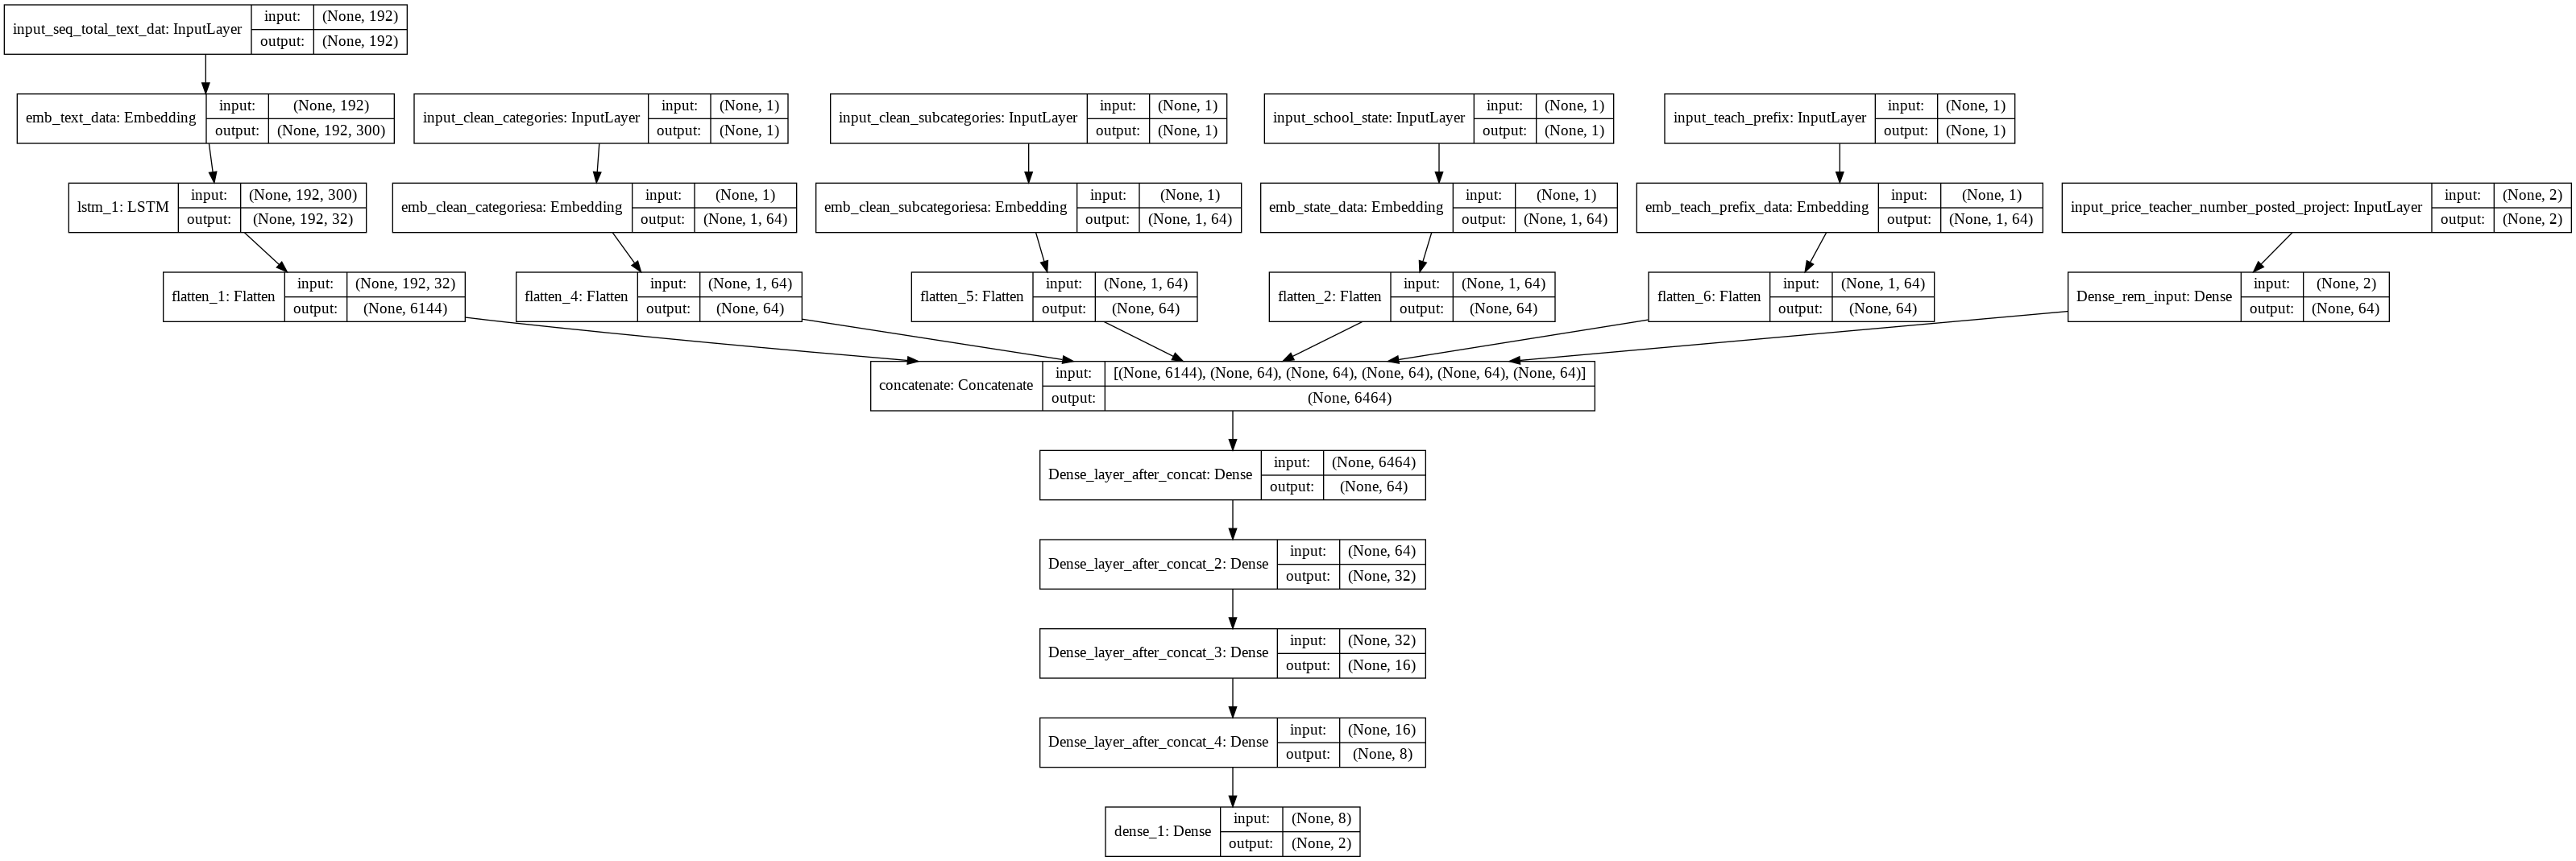

In [0]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model2, to_file='/content/drive/My Drive/model2.png', show_shapes=True, show_layer_names=True)

In [0]:
# summarize the model
print(model2.summary())


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_seq_total_text_dat (Input (None, 192)          0                                            
__________________________________________________________________________________________________
emb_text_data (Embedding)       (None, 192, 300)     14208300    input_seq_total_text_dat[0][0]   
__________________________________________________________________________________________________
input_clean_categories (InputLa (None, 1)            0                                            
__________________________________________________________________________________________________
input_clean_subcategories (Inpu (None, 1)            0                                            
____________________________________________________________________________________________

In [51]:
adam=keras.optimizers.Adam(lr=0.01)
model2.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy',auroc])



Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath="/content/drive/My Drive/model2-epochs:{epoch:03d}.hdf5"
checkpoint_3 = ModelCheckpoint(filepath, monitor='val_auroc', verbose=1, mode='max',save_best_only=True)

In [56]:
#https://github.com/taomanwai/tensorboardcolab/
from time import time
import keras
from tensorboardcolab import *
#https://github.com/taomanwai/tensorboardcolab/
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://3987b100.ngrok.io


In [0]:

callbacks_list = [checkpoint_3,TensorBoardColabCallback(tbc)]


In [0]:

history=model2.fit([train_padded_essays,tr_school_state_le,tr_project_grade_category_le,tr_categories_le,tr_clean_subcategories_le,tr_teacher_prefix_le,tr_X_num],y_train,epochs=20,batch_size=400,verbose=1,validation_data=([cv_padded_essays,cv_school_state_le,cv_project_grade_category_le,cv_categories_le,cv_clean_subcategories_le,cv_teacher_prefix_le,cv_X_num], y_cv),callbacks=callbacks_list)

Train on 69918 samples, validate on 17480 samples
Epoch 1/20
69918/69918 [==============================] - 76s 1ms/step - loss: 0.6134 - acc: 0.8462 - auroc: 0.6859 - val_loss: 0.5419 - val_acc: 0.8474 - val_auroc: 0.7143

Epoch 00001: saving model to /content/drive/My Drive/model2-epochs:001.hdf5
Epoch 2/20
69918/69918 [==============================] - 75s 1ms/step - loss: 0.5042 - acc: 0.8504 - auroc: 0.7345 - val_loss: 0.4902 - val_acc: 0.8480 - val_auroc: 0.7257

Epoch 00002: saving model to /content/drive/My Drive/model2-epochs:002.hdf5
Epoch 3/20
69918/69918 [==============================] - 75s 1ms/step - loss: 0.4607 - acc: 0.8522 - auroc: 0.7526 - val_loss: 0.4628 - val_acc: 0.8485 - val_auroc: 0.7255

Epoch 00003: saving model to /content/drive/My Drive/model2-epochs:003.hdf5
Epoch 4/20
69918/69918 [==============================] - 75s 1ms/step - loss: 0.4313 - acc: 0.8560 - auroc: 0.7693 - val_loss: 0.4500 - val_acc: 0.8413 - val_auroc: 0.7226

Epoch 00004: saving model 

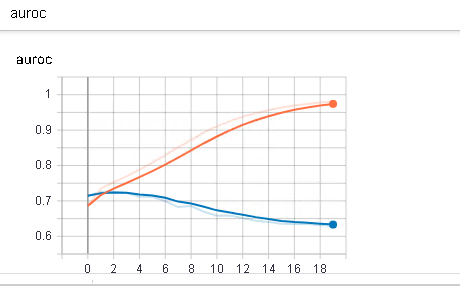

In [0]:
from IPython.display import Image
Image('C:\\Users\\nnagari\\Downloads\\model_2_auc.PNG')

In [0]:
model2.load_weights('/content/drive/My Drive/model2-epochs:002.hdf5')

In [64]:

model2.evaluate([test_padded_essays,te_school_state_le,te_project_grade_category_le,te_categories_le,te_clean_subcategories_le,te_teacher_prefix_le,te_X_num],y_test,batch_size=100)

21850/21850 [==============================] - 39s 2ms/step


[0.45271887706946456, 0.8511212818682603, 0.7369468280421273]

<h1>Model-3

In [0]:
len_essay=[]
for sentance1 in (X_train['essay'].values):
    len_essay.append(len(sentance1.split()))
num_essay=np.array(len_essay)
max_length=num_essay.max()

In [0]:
max_length

311

In [0]:
#text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['essay'])
train_encoded_essays = tokenizer.texts_to_sequences(X_train['essay'])
train_padded_essays = pad_sequences(train_encoded_essays, maxlen=max_length,padding='post')

test_encoded_essays = tokenizer.texts_to_sequences(X_test['essay'])
test_padded_essays = pad_sequences(test_encoded_essays, maxlen=max_length,padding='post')


cv_encoded_essays = tokenizer.texts_to_sequences(X_cv['essay'])
cv_padded_essays = pad_sequences(cv_encoded_essays, maxlen=max_length,padding='post')

vocab_size = len(tokenizer.word_index) + 1

In [0]:
from sklearn.preprocessing import StandardScaler
#essay_stand = StandardScaler().fit(train_padded_essays)
tr_text__nor = train_padded_essays
cv_text__nor = cv_padded_essays
te_text__nor = test_padded_essays
print(tr_text__nor.shape)

(69918, 311)


In [0]:
#loading golve model
import pickle
with open('/content/drive/My Drive/glove_vectors', 'rb') as f:
    glove = pickle.load(f)

In [0]:
word_vector=np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    vector=glove.get(word)
    if vector is not None:
        word_vector[i]=vector   

In [0]:
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

In [0]:
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

In [0]:
# we use count vectorizer to convert the values into one hot encoded features
# Project subcategories
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_subcategories = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)

tr_sub_categories_one_hot=vectorizer_subcategories.fit_transform(X_train['clean_subcategories'].values)
print(vectorizer_subcategories.get_feature_names())

cv_sub_categories_one_hot = vectorizer_subcategories.transform(X_cv['clean_subcategories'].values)
te_sub_categories_one_hot = vectorizer_subcategories.transform(X_test['clean_subcategories'].values)

print(tr_sub_categories_one_hot.toarray()[0:2])
print("\nShape of matrix after one hot encodig for 'Project sub categories'\nTrain data-{},\nCV data\t-{}\nTest data-{}".format(tr_sub_categories_one_hot.shape,cv_sub_categories_one_hot.shape,te_sub_categories_one_hot.shape))

['economics', 'communityservice', 'financialliteracy', 'parentinvolvement', 'extracurricular', 'civics_government', 'foreignlanguages', 'nutritioneducation', 'socialsciences', 'performingarts', 'charactereducation', 'teamsports', 'other', 'college_careerprep', 'warmth', 'care_hunger', 'music', 'history_geography', 'health_lifescience', 'earlydevelopment', 'esl', 'gym_fitness', 'environmentalscience', 'history_civics', 'visualarts', 'health_wellness', 'music_arts', 'appliedsciences', 'appliedlearning', 'health_sports', 'literature_writing', 'specialneeds', 'mathematics', 'literacy', 'math_science', 'literacy_language']
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]]

Shape of matrix after one hot encodig for 'Project sub categories'
Train data-(69918, 36),
CV data	-(17480, 36)
Test data-(21850, 36)


In [0]:
# we use count vectorizer to convert the values into one hot encoded features
# Project categories
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_categories = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()),lowercase=False, binary=True)

tr_categories_one_hot=vectorizer_categories.fit_transform(X_train['clean_categories'].values)
print(vectorizer_categories.get_feature_names())

cv_categories_one_hot =vectorizer_categories.transform(X_cv['clean_categories'].values)
te_categories_one_hot =vectorizer_categories.transform(X_test['clean_categories'].values)

print(tr_categories_one_hot.toarray()[0:1])
print("\nShape of matrix after one hot encodig for 'Project categories'\nTrain data-{},\nCV data\t-{}\nTest data-{}".format(tr_categories_one_hot.shape,cv_categories_one_hot.shape,te_categories_one_hot.shape))

['warmth', 'care_hunger', 'history_civics', 'music_arts', 'appliedlearning', 'specialneeds', 'health_sports', 'math_science', 'literacy_language']
[[0 0 0 0 0 0 0 0 1]]

Shape of matrix after one hot encodig for 'Project categories'
Train data-(69918, 9),
CV data	-(17480, 9)
Test data-(21850, 9)


In [0]:
# you can do the similar thing with state, teacher_prefix and project_grade_category also
# we use count vectorizer to convert the values into one hot encoded features
#teacher_prefix
vectorizer_teacher_prefix = CountVectorizer(lowercase=False, binary=True)
tr_teacher_prefix_one_hot=vectorizer_teacher_prefix.fit_transform(X_train['teacher_prefix'].values.astype('str'))
print(vectorizer_teacher_prefix.get_feature_names())

cv_teacher_prefix_one_hot = vectorizer_teacher_prefix.transform(X_cv['teacher_prefix'].values.astype('str'))
te_teacher_prefix_one_hot = vectorizer_teacher_prefix.transform(X_test['teacher_prefix'].values.astype('str'))

print(tr_teacher_prefix_one_hot.toarray()[0:1])
print("\nShape of matrix after one hot encodig for 'teacher_prefix'\nTrain data-{},\nCV data\t-{}\nTest data-{}".format(tr_teacher_prefix_one_hot.shape,cv_teacher_prefix_one_hot.shape,te_teacher_prefix_one_hot.shape))

['dr', 'mr', 'mrs', 'ms', 'teacher']
[[0 0 1 0 0]]

Shape of matrix after one hot encodig for 'teacher_prefix'
Train data-(69918, 5),
CV data	-(17480, 5)
Test data-(21850, 5)


In [0]:
# we use count vectorizer to convert the values into one hot encoded features
#school_state
vectorizer_school_state = CountVectorizer(lowercase=False, binary=True)
tr_school_state_one_hot=vectorizer_school_state.fit_transform(X_train['school_state'].values.astype('str'))
print(vectorizer_school_state.get_feature_names())

cv_school_state_one_hot = vectorizer_school_state.transform(X_cv['school_state'].values.astype('str'))
te_school_state_one_hot = vectorizer_school_state.transform(X_test['school_state'].values.astype('str'))

print(tr_school_state_one_hot.toarray()[0:1])
print("\nShape of matrix after one hot encodig for 'teacher_prefix'\nTrain data-{},\nCV data\t-{}\nTest data-{}".format(tr_school_state_one_hot.shape,cv_school_state_one_hot.shape,te_school_state_one_hot.shape))

['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]

Shape of matrix after one hot encodig for 'teacher_prefix'
Train data-(69918, 51),
CV data	-(17480, 51)
Test data-(21850, 51)


In [0]:
    # we use count vectorizer to convert the values into one hot encoded features
    #project_grade_category
    vectorizer_grade_category = CountVectorizer(lowercase=False, binary=True)
    tr_grade_category_one_hot=vectorizer_grade_category.fit_transform(X_train['project_grade_category'])
    print(vectorizer_grade_category.get_feature_names())

    cv_grade_category_one_hot = vectorizer_grade_category.transform(X_cv['project_grade_category'])
    te_grade_category_one_hot = vectorizer_grade_category.transform(X_test['project_grade_category'])

    print(tr_grade_category_one_hot.toarray()[0:1])
    print(cv_grade_category_one_hot.toarray()[0:1])
    print(te_grade_category_one_hot.toarray()[0:1])
    print("\nShape of matrix after one hot encodig for 'project_grade_category'\nTrain data-{},\nCV data\t-{}\nTest data-{}".format(tr_grade_category_one_hot.shape,cv_grade_category_one_hot.shape,te_grade_category_one_hot.shape))

['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
[[0 0 0 1]]
[[0 1 0 0]]
[[1 0 0 0]]

Shape of matrix after one hot encodig for 'project_grade_category'
Train data-(69918, 4),
CV data	-(17480, 4)
Test data-(21850, 4)


In [0]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(X_train['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
tr_price_standardized=price_scalar.fit_transform(X_train['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
cv_price_standardized = price_scalar.transform(X_cv['price'].values.reshape(-1, 1))
te_price_standardized = price_scalar.transform(X_test['price'].values.reshape(-1, 1))

Mean : 298.17651634772164, Standard deviation : 359.92483517322444


In [0]:
#teacher_number_of_previously_posted_projects
teacher_number_of_previously_posted_projects_scalar = StandardScaler()
tr_teacher_number_of_previously_posted_projects_standardized=teacher_number_of_previously_posted_projects_scalar.fit_transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {teacher_number_of_previously_posted_projects_scalar.mean_[0]}, Standard deviation : {np.sqrt(teacher_number_of_previously_posted_projects_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
cv_teacher_number_of_previously_posted_projects_standardized = teacher_number_of_previously_posted_projects_scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
te_teacher_number_of_previously_posted_projects_standardized = teacher_number_of_previously_posted_projects_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
print("\nShape of matrix after column standardization for 'teacher_number_of_previously_posted_projects'\nTrain data-{},\nCV data\t-{}\nTest data-{}".format(tr_teacher_number_of_previously_posted_projects_standardized.shape,cv_teacher_number_of_previously_posted_projects_standardized.shape,te_teacher_number_of_previously_posted_projects_standardized.shape))

Mean : 11.247475614291027, Standard deviation : 28.000278112533355

Shape of matrix after column standardization for 'teacher_number_of_previously_posted_projects'
Train data-(69918, 1),
CV data	-(17480, 1)
Test data-(21850, 1)


In [0]:
#merging all columns 
from scipy.sparse import hstack
tr_other_text=hstack((tr_school_state_one_hot,tr_grade_category_one_hot,tr_categories_one_hot,tr_sub_categories_one_hot,tr_teacher_prefix_one_hot,tr_teacher_number_of_previously_posted_projects_standardized,tr_price_standardized)).todense()
cv_other_text=hstack((cv_school_state_one_hot,cv_grade_category_one_hot,cv_categories_one_hot,cv_sub_categories_one_hot,cv_teacher_prefix_one_hot,cv_teacher_number_of_previously_posted_projects_standardized,cv_price_standardized)).todense()
te_other_text=hstack((te_school_state_one_hot,te_grade_category_one_hot,te_categories_one_hot,te_sub_categories_one_hot,te_teacher_prefix_one_hot,te_teacher_number_of_previously_posted_projects_standardized,te_price_standardized)).todense()

In [0]:
tr_other_text = np.array(tr_other_text).reshape(69918,107,1)
cv_other_text = np.array(cv_other_text).reshape(17480, 107,1)
te_other_text = np.array(te_other_text).reshape(21850, 107,1)

In [0]:
from keras import backend as K
K.clear_session()
#total text data
input_total_text=Input(shape=(max_length,),name="input_seq_total_text_dat")
emedding_layer_total_text = Embedding(vocab_size,300, weights=[word_vector], input_length=max_length, trainable=False,name="emb_text_data")(input_total_text)
lstm_layer_total_text=LSTM(128,kernel_initializer='glorot_normal',return_sequences=True)(emedding_layer_total_text)
#lstm_layer_total_text= ReLU()(lstm_layer_total_text)
flat_layer_total_text=Flatten()(lstm_layer_total_text)

other_input = Input(shape=(tr_other_text.shape[1],1), name='other_input')
#emedding_layer_other=Embedding(input_dim=tr_other_text.shape[1],output_dim=400, input_length=tr_other_text.shape[1])(other_input)
conv_layer_other=Conv1D(32,7, activation='relu',padding='same',kernel_initializer='glorot_normal',strides=1)(other_input)
conv_layer_other=Conv1D(16,3, activation='relu',padding='same',kernel_initializer='glorot_normal',strides=2)(conv_layer_other)

#pool_layer_other=MaxPooling1D(pool_size=3)(other_input)
flat_layer_other = Flatten()(conv_layer_other)



concat_layer = concatenate([flat_layer_total_text,flat_layer_other])

dense_layer_after_concat=Dense(32,name="Dense_layer_after_concat",kernel_initializer='he_normal',activation='relu',kernel_regularizer=l2(0.0001))(concat_layer)
#dense_layer_after_concat=ReLU()(dense_layer_after_concat)
#dropout layer 1
dropout_1=Dropout(0.5,name="Dropout_1")(dense_layer_after_concat)
#dense layer 2
dense_layer_after_concat_2=Dense(32,name="Dense_layer_after_concat_2",kernel_initializer='he_normal',activation='relu',kernel_regularizer=l2(0.0001))(dropout_1)
#dense_layer_after_concat_2=ReLU()(dense_layer_after_concat_2)
#dropout layer 2
#dropout_2=Dropout(0.5,name="Dropout_2")(dense_layer_after_concat_2)
#dense layer 3
dense_layer_after_concat_3=Dense(16,name="Dense_layer_after_concat_3",kernel_initializer='he_normal',activation='relu',kernel_regularizer=l2(0.0001))(dense_layer_after_concat_2)
#dense_layer_after_concat_3=ReLU()(dense_layer_after_concat_3)
output_layer=Dense(2, activation='softmax',kernel_initializer='glorot_uniform')(dense_layer_after_concat_3)

model3=Model(inputs=[input_total_text,other_input],outputs=output_layer)







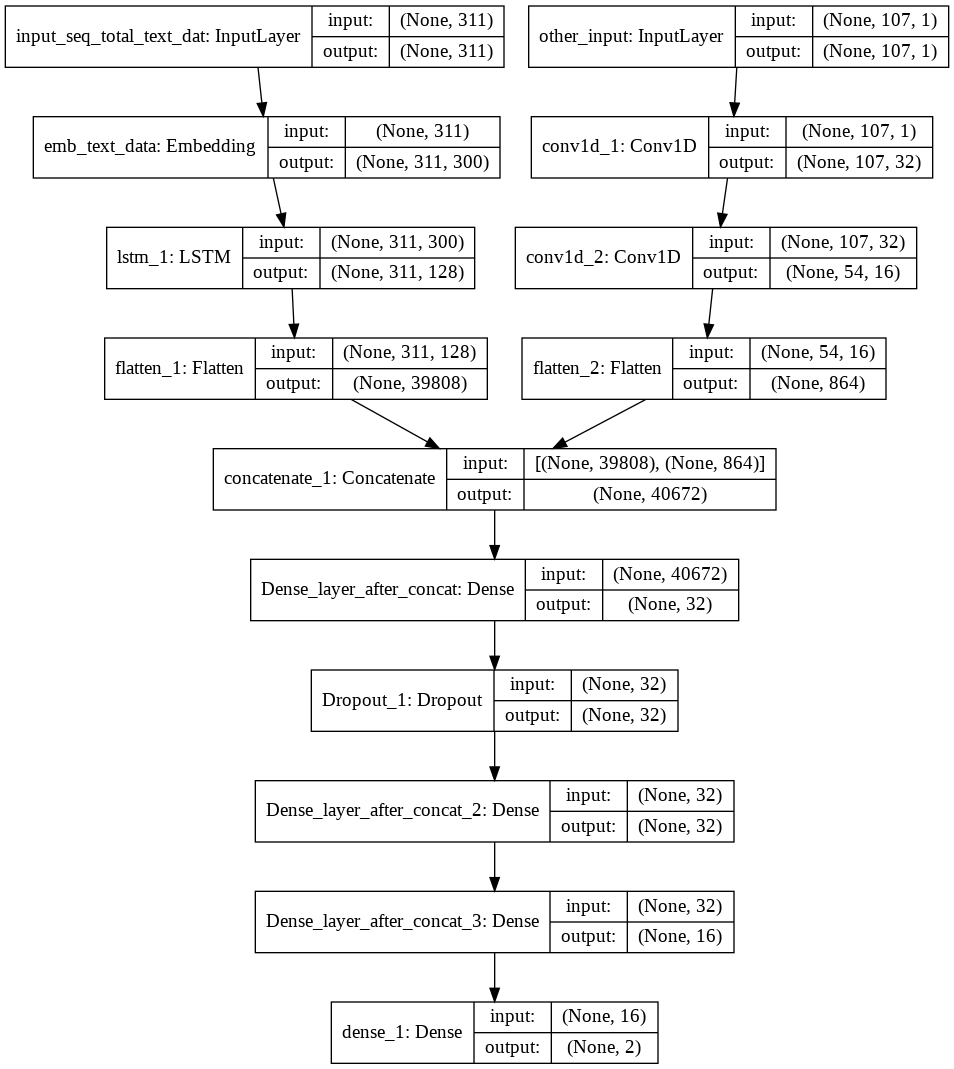

In [0]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model3, to_file='/content/drive/My Drive/model3.png', show_shapes=True, show_layer_names=True)

In [0]:
# summarize the model
print(model3.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_seq_total_text_dat (Input (None, 320)          0                                            
__________________________________________________________________________________________________
other_input (InputLayer)        (None, 107, 1)       0                                            
__________________________________________________________________________________________________
emb_text_data (Embedding)       (None, 320, 300)     14132700    input_seq_total_text_dat[0][0]   
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 107, 32)      256         other_input[0][0]                
____________________________________________________________________________________________

In [0]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score
def auc( y_true, y_pred ) :
    score = tf.py_func( lambda y_true, y_pred : roc_auc_score( y_true, y_pred).astype('float32'),
                        [y_true, y_pred],
                        'float32',
                        stateful=True,
                        name='sklearnAUC' )
    return score

In [0]:
adam=keras.optimizers.Adam(lr=10,decay = 1e-4)
model3.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy',auc])

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath="/content/drive/My Drive/model3-epochs:{epoch:03d}.hdf5"
checkpoint_3 = ModelCheckpoint(filepath, monitor='val_auc', verbose=1,save_best_only=True, mode='max')

In [0]:
#https://github.com/taomanwai/tensorboardcolab/
from time import time
import keras
from tensorboardcolab import *
#https://github.com/taomanwai/tensorboardcolab/
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://2f3c78e8.ngrok.io


In [0]:

callbacks_list = [checkpoint_3,TensorBoardColabCallback(tbc)]

history=model3.fit([tr_text__nor,tr_other_text],y_train,epochs=20,batch_size=2000,verbose=1,validation_data=([cv_text__nor,cv_other_text], y_cv),callbacks=callbacks_list,class_weight = "balanced")

Train on 69918 samples, validate on 17480 samples
Epoch 1/20
69918/69918 [==============================] - 21s 301us/step - loss: 0.4888 - acc: 0.8400 - auc: 0.5679 - val_loss: 0.4446 - val_acc: 0.8507 - val_auc: 0.6654

Epoch 00001: val_auc improved from -inf to 0.66538, saving model to /content/drive/My Drive/model3-epochs:001.hdf5
Epoch 2/20
69918/69918 [==============================] - 20s 289us/step - loss: 0.4193 - acc: 0.8492 - auc: 0.6754 - val_loss: 0.4275 - val_acc: 0.8509 - val_auc: 0.7137

Epoch 00002: val_auc improved from 0.66538 to 0.71367, saving model to /content/drive/My Drive/model3-epochs:002.hdf5
Epoch 3/20
69918/69918 [==============================] - 20s 290us/step - loss: 0.4007 - acc: 0.8498 - auc: 0.7194 - val_loss: 0.4049 - val_acc: 0.8519 - val_auc: 0.7361

Epoch 00003: val_auc improved from 0.71367 to 0.73611, saving model to /content/drive/My Drive/model3-epochs:003.hdf5
Epoch 4/20
69918/69918 [==============================] - 20s 289us/step - loss: 0.

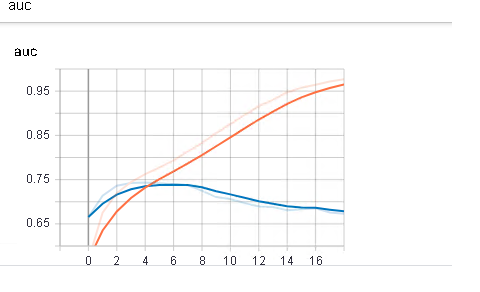

In [0]:
from IPython.display import Image
Image('C:\\Users\\nnagari\\Downloads\\model_3_auc.png')

In [0]:
model3.load_weights('/content/drive/My Drive/model3-epochs:005.hdf5')

In [0]:
model3.evaluate([te_text__nor,te_other_text],y_test,batch_size=100)

21850/21850 [==============================] - 35s 2ms/step


[0.4116582988465132, 0.8510297487747751, 0.7457665919711988]

In [72]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
table = PrettyTable()

table.field_names = ["Models", "Train","CV","Test"]

table.add_row(["Model-1", "0.7651","0.7429","0.7532"])
table.add_row(["Model-2", "0.7345","0.7252","0.7369"])
table.add_row(["Model-3", "0.7625", "0.7435","0.7457"])

print(table)

+---------+--------+--------+--------+
|  Models | Train  |   CV   |  Test  |
+---------+--------+--------+--------+
| Model-1 | 0.7651 | 0.7429 | 0.7532 |
| Model-2 | 0.7345 | 0.7252 | 0.7369 |
| Model-3 | 0.7625 | 0.7435 | 0.7457 |
+---------+--------+--------+--------+
